# Bayesian Linear Regression in PyMC3

<div class="alert alert-block alert-warning">
<b>Work in progress:</b> This notebook is still being developed.
</div>

In this notebook, I'd like to take a look in how to perform linear regression from a Bayesian perspective

In [1]:
import multiprocessing
import theano
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

n_cores = multiprocessing.cpu_count()

plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [2]:
np.random.seed(42)
n = 350
true_intercept = 1
true_slope = 2

x = np.linspace(0, 3, n)
# y = a + b*x
y_true = true_intercept + true_slope * x
# add noise
y = y_true + np.random.normal(loc=0, scale=0.5, size=n)

In [3]:
train_size = 0.65
train_idx = np.random.choice(np.arange(0,n), size=round(train_size*n), replace=False)

x_train = x[train_idx].copy()
y_train = y[train_idx].copy()

x_test = np.delete(x, train_idx)
y_test = np.delete(y, train_idx)



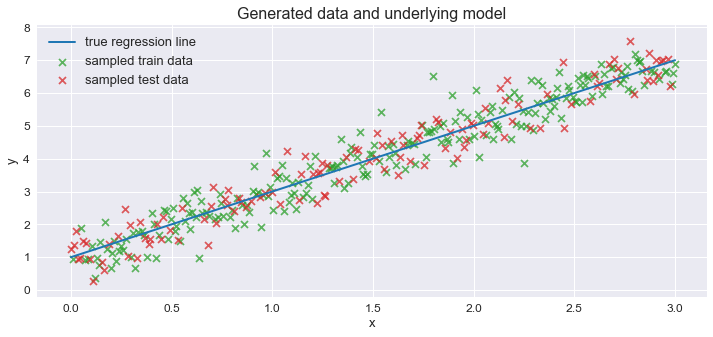

In [4]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.scatter(x_train, y_train, marker='x', label='sampled train data', color='tab:green', alpha=0.75)
ax.scatter(x_test, y_test, marker='x', label='sampled test data', color='tab:red',  alpha=0.75)
ax.plot(x, y_true, label='true regression line', lw=2, color='tab:blue')
plt.legend()
plt.show()

In [5]:
x_shared = theano.shared(x_train)
y_shared = theano.shared(y_train)

with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('intercept', 0, sigma=20)
    x_coeff = pm.Normal('x_coeff', 0, sigma=20)
    
    y = pm.Normal('y', mu=intercept + x_coeff * x_shared,
                        sigma=sigma, observed=y_shared)
    
    trace = pm.sample(draws=5000, cores=n_cores-1, tune=1000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '11782' (I am process '25148')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [x_coeff, intercept, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 42000/42000 [00:12<00:00, 3296.43draws/s]


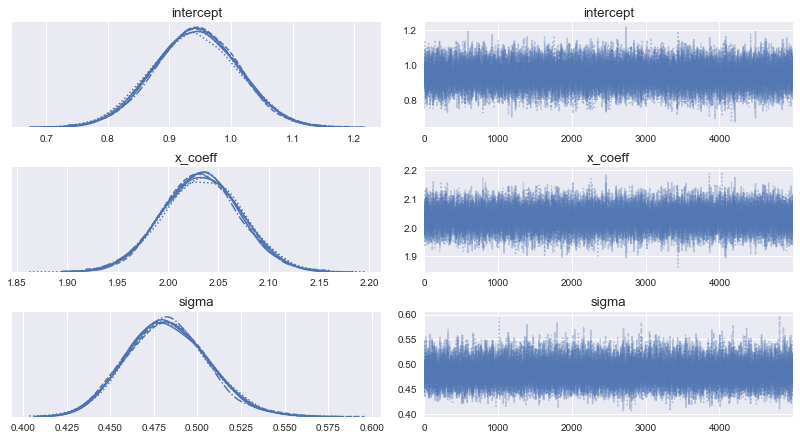

In [6]:
pm.traceplot(trace, figsize=(11,6));

In [7]:
posterior = pm.sample_posterior_predictive(trace, samples=100, model=model)

/Users/disargia/opt/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:01<00:00, 98.03it/s]


In [8]:
mu = trace['intercept'] + trace['x_coeff']*x_train.reshape(-1,1)

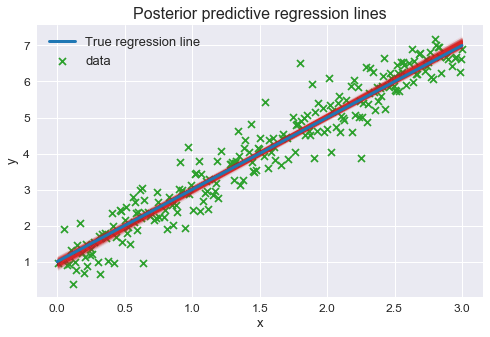

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(x_train, y_train, marker='x', label='data', color='tab:green')
# plot_posterior(trace, samples=100, label='Posterior predictive regression lines')
plt.plot(x_train, mu[..., 10:500], c='tab:red', alpha=0.03)
plt.plot(x, y_true, label='True regression line', linewidth=3, color='tab:blue')

plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
x_shared.set_value(x_test)
y_shared.set_value(np.zeros(len(y_test)))

with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1250)

/Users/disargia/opt/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1250/1250 [00:11<00:00, 112.88it/s]


In [11]:
post_pred['y'].std(axis=0).shape

(122,)

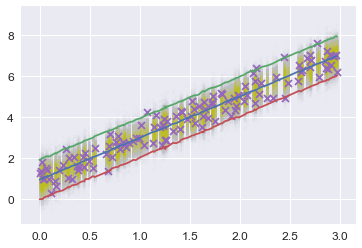

In [12]:
for i in range(1250):
    plt.scatter(x_test, post_pred['y'].T[:,i], color='tab:olive', marker='.', alpha=0.002)
plt.scatter(x_test, y_test, color='tab:purple', marker='x')
plt.plot(x_test,post_pred['y'].mean(axis=0))
plt.plot(x_test,post_pred['y'].mean(axis=0)+2*post_pred['y'].std(axis=0))
plt.plot(x_test,post_pred['y'].mean(axis=0)-2*post_pred['y'].std(axis=0));


# Making the variance $x$ dependent

In [13]:
np.random.seed(42)
n = 350
true_intercept = 1
true_slope = 2

x = np.linspace(0, 3, n)
# y = a + b*x
y_true = true_intercept + true_slope * x
# add noise
x_dep_var = 2*np.sin(x*2*np.pi/3)*np.sin(x*(2*np.pi))
x_dep_var = 0.8*x
y = y_true + np.random.normal(loc=0, scale=0.5, size=n)*np.abs(x_dep_var) + np.random.normal(loc=0, scale=.333, size=n)

In [14]:
train_size = 0.65
train_idx = np.random.choice(np.arange(0,n), size=round(train_size*n), replace=False)

x_train = x[train_idx].copy()
y_train = y[train_idx].copy()

x_test = np.delete(x, train_idx)
y_test = np.delete(y, train_idx)



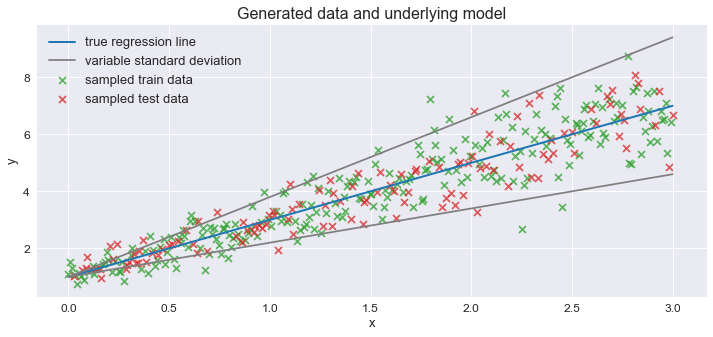

In [15]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.scatter(x_train, y_train, marker='x', label='sampled train data', color='tab:green', alpha=0.75)
ax.scatter(x_test, y_test, marker='x', label='sampled test data', color='tab:red',  alpha=0.75)
ax.plot(x, y_true, label='true regression line', lw=2, color='tab:blue')
ax.plot(x, true_intercept+true_slope * x+x_dep_var, c='tab:gray', label='variable standard deviation')
ax.plot(x, true_intercept+true_slope * x-x_dep_var, c='tab:gray')
plt.legend()
plt.show()

In [27]:
x_shared = theano.shared(x_train)
y_shared = theano.shared(y_train)

with pm.Model() as model_var:
    sigma_base = pm.HalfCauchy('sigma_base', beta=10, testval=1.)
    sigma_scale = pm.HalfCauchy('sigma_scale', beta=10, testval=1.)
    sigma = pm.Deterministic('sigma', sigma_base + sigma_scale * x_shared)
    
    intercept = pm.Normal('intercept', 0, sigma=20)
    x_coeff = pm.Normal('x_coeff', 0, sigma=20)
    
    y = pm.Normal('y', mu=intercept + x_coeff * x_shared,
                        sigma=sigma, observed=y_shared)
    
    trace = pm.sample(draws=5000, cores=n_cores-1, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [x_coeff, intercept, sigma_scale, sigma_base]
Sampling 7 chains, 0 divergences: 100%|██████████| 42000/42000 [00:14<00:00, 2845.38draws/s]


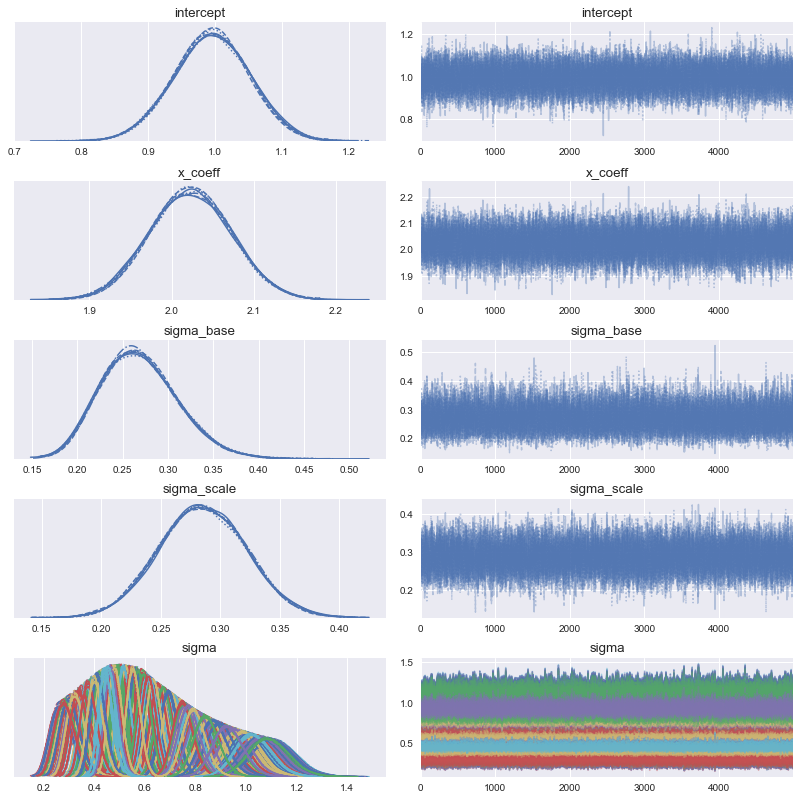

In [28]:
pm.traceplot(trace, figsize=(11,11));

In [29]:
mu = trace['intercept'] + trace['x_coeff']*x_train.reshape(-1,1)

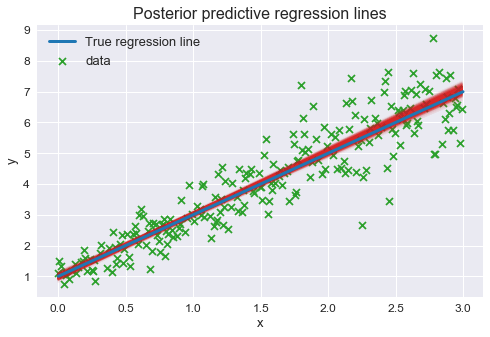

In [30]:
plt.figure(figsize=(8,5))
plt.scatter(x_train, y_train, marker='x', label='data', color='tab:green')
# plot_posterior(trace, samples=100, label='Posterior predictive regression lines')
plt.plot(x_train, mu[..., 10:500], c='tab:red', alpha=0.03)
plt.plot(x, y_true, label='True regression line', linewidth=3, color='tab:blue')

plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [38]:
x_shared.set_value(x_test)
y_shared.set_value(np.zeros(len(y_test)))

with model_var:
    post_pred = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [01:55<00:00, 86.29it/s]


No handles with labels found to put in legend.


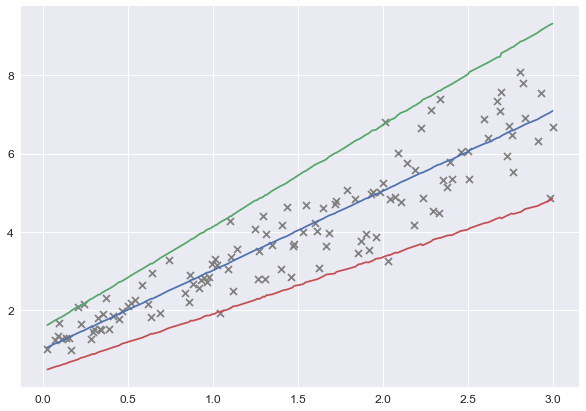

In [40]:
# for i in range(1250):
#     plt.scatter(x_test, post_pred['y'].T[:,i], color='tab:green', marker='o', alpha=0.002)
plt.figure(figsize=(10,7))
plt.scatter(x_test, y_test, color='tab:grey', marker='x')
plt.plot(x_test,post_pred['y'].mean(axis=0))
plt.plot(x_test,post_pred['y'].mean(axis=0)+2*post_pred['y'].std(axis=0))
plt.plot(x_test,post_pred['y'].mean(axis=0)-2*post_pred['y'].std(axis=0))
# plt.plot(x, true_intercept+true_slope * x+x_dep_var, c='tab:gray', label='variable standard deviation')
# plt.plot(x, true_intercept+true_slope * x-x_dep_var, c='tab:gray')
plt.legend()
plt.show()